# Get 6C Data for Event

Get 6C data for ROMY and store it

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client

from andbro__read_sds import __read_sds

Matplotlib is building the font cache; this may take a moment.


In [2]:
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.get_event_info import __get_event_info

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_outdata'] = data_path+"romy_events/data/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

## BSPF coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941

# specify mask for ADR
config['submask'] = ""

# specify frequency band
config['fmin'] = 0.01
config['fmax'] = 0.1

# specify client
config['Client'] = Client("GFZ")

# specify if ADR is computed
config['adr'] = True

# config['seed_acc'] = "BW.DROMY..HH*"
config['seed_acc'] = "GR.FUR..BH*"


config['path_to_rot'] = archive_path+"romy_archive/"

if "DROMY" in config['seed_acc']:
    config['path_to_acc'] = archive_path+"romy_archive/"
elif "FUR" in config['seed_acc']:
    config['path_to_acc'] = bay_path+"mseed_online/archive/"

## Eventtime
# config['eventtime'] = obs.UTCDateTime("2023-10-25 13:40:00")

# config['event_name'] = "Italy"
# config['tbeg'] = obs.UTCDateTime("2023-10-25 13:45:00")
# config['tend'] = obs.UTCDateTime("2023-10-25 13:50:00")

config['event_name'] = "Morocco"
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00")

# config['event_name'] = "Morocco2"
# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:30")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:30")

# config['event_name'] = "Mindanao" ## M7-6
# config['tbeg'] = obs.UTCDateTime("2023-12-02 14:37")
# config['tend'] = obs.UTCDateTime("2023-12-02 17:00")

# config['event_name'] = "Mindanao2" ## M6.6
# config['tbeg'] = obs.UTCDateTime("2023-12-03 10:35")
# config['tend'] = obs.UTCDateTime("2023-12-03 12:35")

# config['event_name'] = "Meteoride"
# config['tbeg'] = obs.UTCDateTime("2024-01-21 00:15")
# config['tend'] = obs.UTCDateTime("2024-01-21 00:50")

# config['event_name'] = "Montenegro"
# config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
# config['tend'] = obs.UTCDateTime("2024-03-14 03:36")

# config['event_name'] = "distortions"
# config['tbeg'] = obs.UTCDateTime("2023-12-02 18:25:00")
# config['tend'] = obs.UTCDateTime("2023-12-02 18:40:00")

# config['event_name'] = "Germany"
# config['tbeg'] = obs.UTCDateTime("2024-03-22 05:30:00")
# config['tend'] = obs.UTCDateTime("2024-03-22 05:40:00")

# config['event_name'] = "Italy2"
# config['tbeg'] = obs.UTCDateTime("2024-03-27 21:32:00")
# config['tend'] = obs.UTCDateTime("2024-03-27 21:35:00")

# config['event_name'] = "Taiwan"
# config['tbeg'] = obs.UTCDateTime("2024-04-03 00:11:00")
# config['tend'] = obs.UTCDateTime("2024-04-03 03:11:00")

# config['event_name'] = "Noise"
# config['tbeg'] = obs.UTCDateTime("2024-03-29 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-30 00:00")

# config['event_name'] = "Wind"
# config['tbeg'] = obs.UTCDateTime("2024-04-19 00:00")
# config['tend'] = obs.UTCDateTime("2024-04-20 00:00")

# config['event_name'] = "Wind"
# config['tbeg'] = obs.UTCDateTime("2024-03-27 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-28 00:00")


## Load Data

#### Find event in catalog

In [5]:
config, dist, baz, az = __get_event_info(config, min_mag=2)
event = Client("IRIS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=2.0)
event = event[0]

-> more than one event

4 Event(s) in Catalog:
2023-09-08T22:47:02.320000Z | +29.244, +129.379 | 4.99 mb | automatic
2023-09-08T22:30:45.170000Z | +31.057,   -8.311 | 5.31 mb | manual
2023-09-08T22:11:02.680000Z | +31.143,   -8.412 | 6.88 Mw | manual
2023-09-08T22:09:49.810000Z | +25.043, +124.830 | 4.89 M  | automatic


Select Event number:  2


Event:	2023-09-08T22:11:02.680000Z | +31.143,   -8.412 | 6.88 Mw | manual

	                  resource_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/gfz2023rqlr")
	                creation_info: CreationInfo(agency_id='GFZ', creation_time=UTCDateTime(2023, 9, 8, 22, 13, 54, 779175))
	          preferred_origin_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20230908230819.814173.499264")
	       preferred_magnitude_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Magnitude/20230908231953.411263.289784")
	 preferred_focal_mechanism_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/FocalMechanism/20230908231953.41101.289782")
	                         ---------
	           event_descriptions: 1 Elements
	                      origins: 1 Elements
	                   magnitudes: 1 Elements
Distance  2519.881756045694 km Azimuth  35.797384976302894 Backazimuth  228.57446933003882


#### Load inventory

In [6]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")
# romy_inv = obs.read_inventory(config['path_to_inventory']+"../station_BW_ROMY.xml")
# romy_inv = obs.read_inventory(config['path_to_inventory']+"../romy_george.xml")
# romy_inv = obs.read_inventory(config['path_to_inventory']+"../station_BW_ROMY2.xml")

if "DROMY" in config['seed_acc']:
    seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_DROMY")
elif "FUR" in config['seed_acc']:
    seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.GR_FUR")


In [7]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg']-1, config['tend']+1)

if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

st0 = st0.trim(config['tbeg'], config['tend'])
st0

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-08T22:00:00.011600Z - 2023-09-08T23:00:00.011600Z | 20.0 Hz, 72001 samples
BW.ROMY..BJU   | 2023-09-08T21:59:59.999399Z - 2023-09-08T22:59:59.999399Z | 20.0 Hz, 72001 samples
BW.ROMY..BJV   | 2023-09-08T22:00:00.036600Z - 2023-09-08T23:00:00.036600Z | 20.0 Hz, 72001 samples

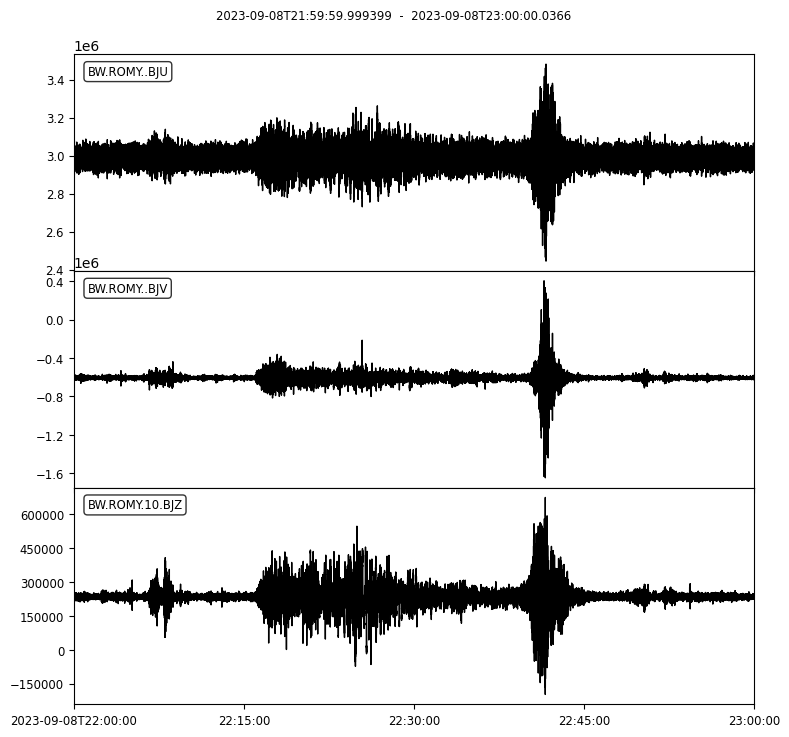

In [8]:
st0.plot(equal_scale=False);

## Process Translation Data

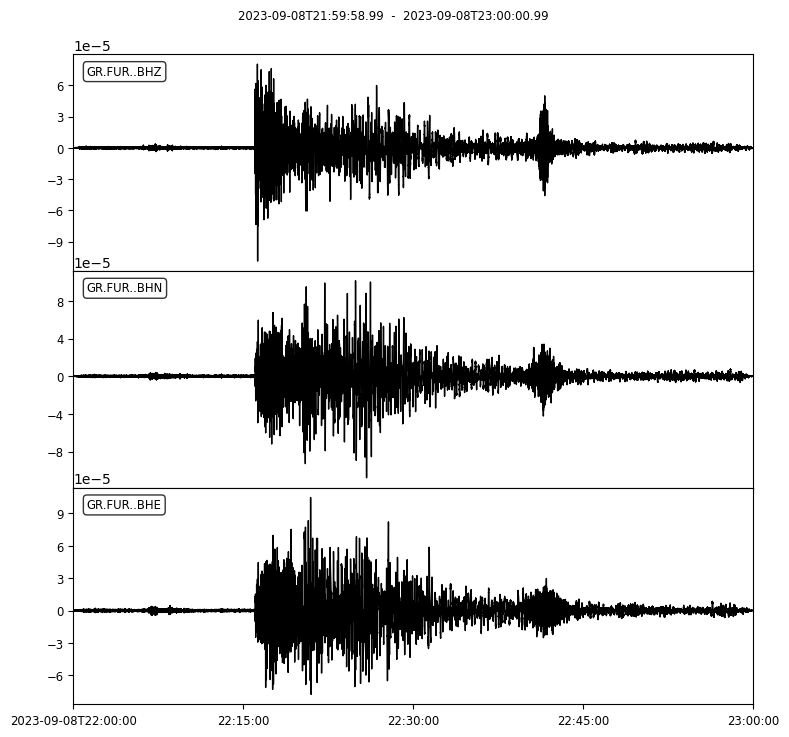

In [9]:
acc = __read_sds(config['path_to_acc'], config['seed_acc'], config['tbeg']-1, config['tend']+1)

acc = acc.remove_response(seis_inv, output="ACC", water_level=60)

acc = acc.detrend("linear")

if "H" in config['seed_acc']:
    acc = acc.resample(20, no_filter=True)

acc.plot(equal_scale=False);

## Process Rotation Data

In [10]:
romy_inv

Inventory created at 2024-05-06T15:12:33.230938Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.4.0
	Contains:
		Networks (1):
			BW
		Stations (1):
			BW.ROMY (RingLaser, Bavaria, BW-Net)
		Channels (14):
			BW.ROMY..BJU, BW.ROMY..BJV, BW.ROMY..BJW, BW.ROMY..HJU, 
			BW.ROMY..HJV, BW.ROMY..HJW, BW.ROMY.10.BJZ, BW.ROMY.10.HJZ, 
			BW.ROMY.20.BJZ, BW.ROMY.20.BJN, BW.ROMY.20.BJE, BW.ROMY.30.BJZ, 
			BW.ROMY.30.BJN, BW.ROMY.30.BJE

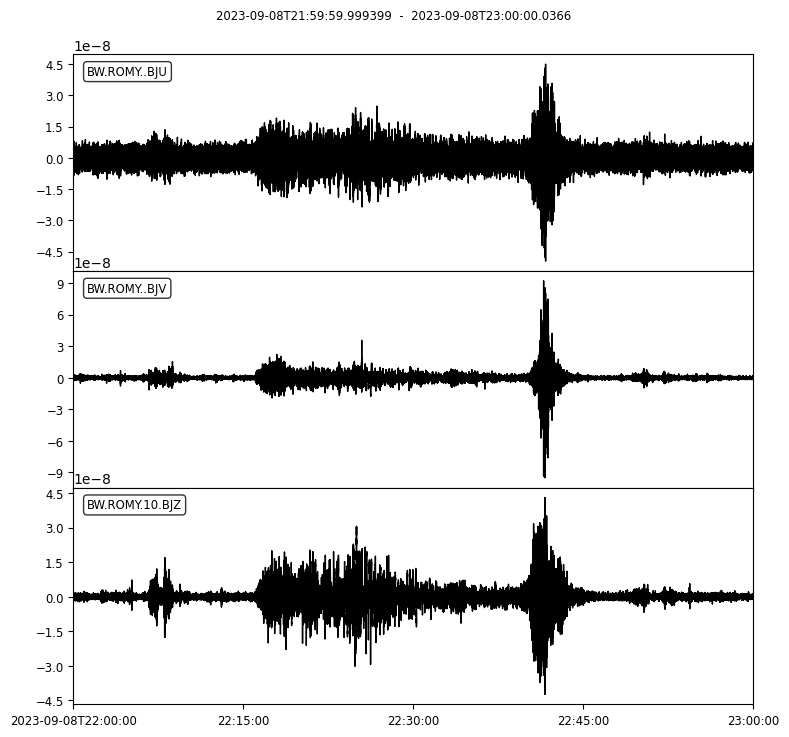

In [11]:
rot = st0.copy()

rot = rot.remove_sensitivity(romy_inv)

rot = rot.detrend("linear")

# rot = rot.taper(0.1)
# rot = rot.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

rot.plot(equal_scale=False);

In [12]:
rot_zne = __rotate_romy_ZUV_ZNE(rot, romy_inv, keep_z=True)

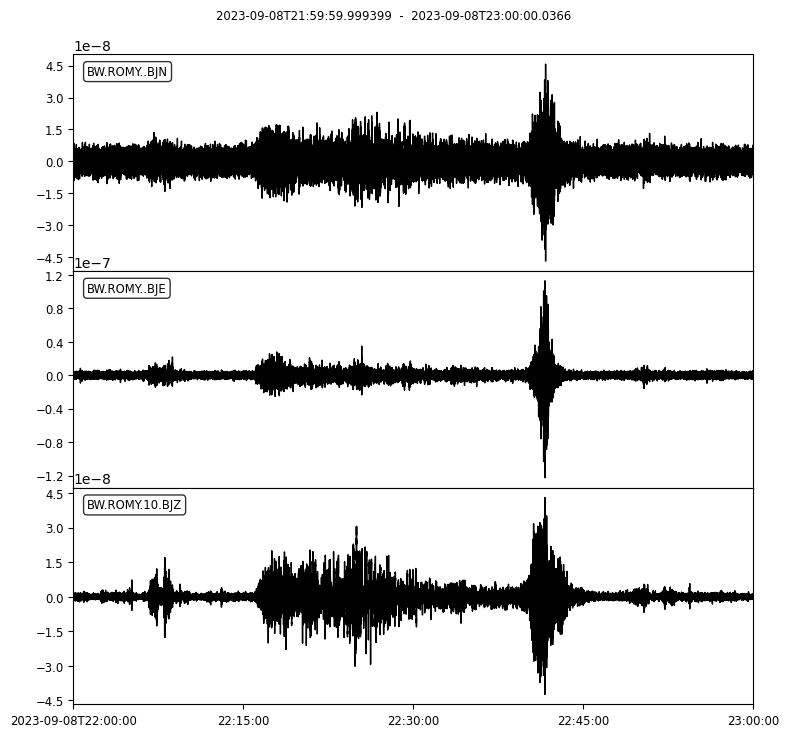

In [13]:
rot_zne.plot(equal_scale=False);

## Compute ADR for ROMY

In [14]:
from functions.compute_adr_romy import __compute_adr_pfo

In [95]:
def __compute_adr_pfo(tbeg, tend, submask='all', status=False, excluded_stations=[]):

    ######################
    """
    rotation_X = -u_nz
    rotation_Y =  u_ez
    rotation_Z = 0.5*(u_ne-u_en)
    """
    ######################

    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.colors

    from obspy import UTCDateTime, Stream, read_inventory
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    if os.uname().nodename == 'lighthouse':
        root_path = '/home/andbro/'
        data_path = '/home/andbro/kilauea-data/'
        archive_path = '/home/andbro/freenas/'
        bay_path = '/home/andbro/bay200/'
    elif os.uname().nodename == 'kilauea':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/bay200/'
    elif os.uname().nodename == 'lin-ffb-01':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/bay200/'

    ## _____________________________________________________

    ## start timer for runtime
    start_timer = timeit.default_timer()


    ## _____________________________________________________

    ## generate configuration object
    config = {}

    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    ## select the fdsn client for the stations
    config['fdsn_client'] = {"BW":Client('http://jane'), "GR":Client('BGR')}

    ## define output seed
    config['out_seed'] = "BW.ADR"

    ## add submask
    config['submask'] = submask

    if config['submask'] == "inner":
        config['location'] = "01"
    elif config['submask'] == "outer":
        config['location'] = "02"
    elif config['submask'] == "all":
        config['location'] = "03"


    ## select stations to consider: 
    if submask is not None:

        if submask == "inner":
            config['subarray_mask'] = [0, 1, 2, 3]
            config['freq1'] = 0.2
            config['freq2'] = 1.0

        elif submask == "outer":
            config['subarray_mask'] = [0, 4, 5, 6, 7, 8]
            config['freq1'] = 0.01
            config['freq2'] = 0.1

        elif submask == "all":
            config['subarray_mask'] = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            config['freq1'] = 0.01
            config['freq2'] = 0.1



    ## decide if information is printed while running the code
    config['print_details'] = False

    ## _____________________
    ## PFO array information

    config['reference_station'] = 'GR.FUR' ## reference station

    config['array_stations'] = ['GR.FUR', 'BW.FFB1', 'BW.FFB2', 'BW.FFB3',
                                'BW.BIB', 'BW.TON', 'BW.GELB', 'BW.ALFT', 'BW.GRMB',
                               ]


#     config['misorientations'] =  [0, 0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375 
#                                   ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]

#     config['subarray_misorientation'] = [config['misorientations'][i] for i in config['subarray_mask']]

    ## select stations of subarray
    config['subarray_stations'] = []
    for i in config['subarray_mask']:
        if config['array_stations'][i] not in excluded_stations:
            config['subarray_stations'].append(config['array_stations'][i])

    config['subarray_sta'] = config['subarray_stations']

    ## ______________________________
    ## parameter for array-derivation

    #config['prefilt'] = (0.001, 0.01, 5, 10)
    config['apply_bandpass'] = True


    # adr parameters
    config['vp'] = 4800 #6264. #1700
    config['vs'] = 3800 #3751. #1000
    config['sigmau'] = 1e-4 # 0.0001


    ## _____________________________________________________


    def __get_inventory_and_distances(config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            loc, cha = "", "BH*"


            try:
                ## load local version
                inven = read_inventory(root_path+f"Documents/ROMY/stationxml_ringlaser/station_{net}_{sta}.xml")

            except:
                inven = config['fdsn_client'][net].get_stations(
                                                                network=net,
                                                                station=sta,
                                                                channel=cha,
                                                                location=loc,
                                                                starttime=config['tbeg'],
                                                                endtime=config['tend'],
                                                                level='response'
                                                                )

            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])


            if sta == "FUR":
                o_lon, o_lat, o_height = l_lon, l_lat, height

            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            coo.append([lon*1000, lat*1000, height-o_height])  ## convert unit from km to m

        return inven, np.array(coo)


    def __check_samples_in_stream(st, config):

        Rnet, Rsta = config['reference_station'].split(".")

        Rsamples = st.select(network=Rnet, station=Rsta)[0].stats.npts

        for tr in st:
            if tr.stats.npts != Rsamples:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {Rsamples})")
                st.remove(tr)

        return st


    def __get_data(config):


        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            loc, cha = "", "BH*"

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


            ## querry inventory data
            try:
                try:
                    ## load local version
                    inventory = read_inventory(root_path+f"Documents/ROMY/stationxml_ringlaser/station_{net}.{sta}.xml")
                    print(f" -> load local inventory")

                except:
                    if sta == "FUR":
                            inventory = read_inventory(root_path+f"Documents/ROMY/stationxml_ringlaser/station_{net}_{sta}.xml")
                    else:
                        inventory = config['fdsn_client'][net].get_stations(
                                                                            network=net,
                                                                            station=sta,
                                                                            location=loc,
                                                                            channel=cha,
                                                                            starttime=config['tbeg']-30,
                                                                            endtime=config['tend']+30,
                                                                            level="response"
                                                                            )
                    print(f" -> load jane inventory")

            except:
                print(f" -> {sta} Failed to load inventory!")
                inventory = None

            ## try to get waveform data
            try:
                stats = config['fdsn_client'][net].get_waveforms(
                                                                network=net,
                                                                station=sta,
                                                                location=loc,
                                                                channel=cha,
                                                                starttime=config['tbeg']-30,
                                                                endtime=config['tend']+30,
                                                                attach_response=False,
                                                                )
            except Exception as E:
                print(E) if config['print_details'] else None
                print(f" -> getting waveforms failed for {net}.{sta}.{loc}.{cha} ...")
                config['stations_loaded'][k] = 0
                continue

            ## merge if masked
            if len(stats) > 3:
                print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
                stats.merge(method=1, fill_value="interpolate")

            ## successfully obtained
            if len(stats) == 3:
                print(f" -> obtained: {net}.{sta}")


            ## remove response [VEL -> rad/s | DISP -> rad]
            # stats = stats.remove_sensitivity(inventory)
            stats.remove_response(inventory, output="VEL", water_level=10, pre_filt=[0.005, 0.008, 8, 10])
            # stats.remove_response(inventory, output="VEL", water_level=60)


            #correct mis-alignment
            # stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
            #                                                          stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
            #                                                          stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)



            ## rotate to ZNE
            try:
                stats = stats.rotate(method="->ZNE", inventory=inventory)
            except:
                print(f" -> {sta} failed to rotate to ZNE")
                continue

            ## resampling using decitmate
            # stats = stats.detrend("linear");
            # stats = stats.taper(0.01);
            # stats = stats.filter("lowpass", freq=8, corners=4, zerophase=True);

            ## resample to same frequency (required for FFB* stations with 40Hz)
            if submask == "inner":
                stats = stats.resample(20.0, no_filter=False)


            if station == config['reference_station']:
                # ref_station = stats.copy().resample(40, no_filter=False)
                ref_station = stats.copy()

            st += stats
            config['subarray'].append(f"{stats[0].stats.network}.{stats[0].stats.station}")

            print(stats)

        ## trim to interval
        # stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

        st = st.sort()

        # st.plot(equal_scale=False);

        config['subarray_stations'] = config['subarray']

        print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config


    def __compute_ADR(tse, tsn, tsz, config, ref_station):

        ## make sure input is array type
        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        ## define array for subarray stations with linear numbering
        substations = np.arange(len(config['subarray_stations']))

        try:
            result = AA.array_rotation_strain(substations,
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['coo'],
                                              config['sigmau'],
                                             )
        except Exception as E:
            print(E)
            print("\n -> failed to compute ADR...")
            return None

        ## create rotation stream and add data
        rotsa = ref_station.copy()

        rotsa[0].data = result['ts_w3']
        rotsa[1].data = result['ts_w2']
        rotsa[2].data = result['ts_w1']

        rotsa[0].stats.channel='BJZ'
        rotsa[1].stats.channel='BJN'
        rotsa[2].stats.channel='BJE'

        rotsa[0].stats.station=config['out_seed'].split(".")[1]
        rotsa[1].stats.station=config['out_seed'].split(".")[1]
        rotsa[2].stats.station=config['out_seed'].split(".")[1]

        rotsa[0].stats.network=config['out_seed'].split(".")[0]
        rotsa[1].stats.network=config['out_seed'].split(".")[0]
        rotsa[2].stats.network=config['out_seed'].split(".")[0]

        rotsa[0].stats.location=config['location']
        rotsa[1].stats.location=config['location']
        rotsa[2].stats.location=config['location']

        rotsa = rotsa.detrend('linear')

    #     gradient_ZNE = result['ts_ptilde'] #u1,1 u1,2 u1,3 u2,1 u2,2 u2,3
    #     u_ee=gradient_ZNE[:,0]
    #     u_en=gradient_ZNE[:,1]
    #     u_ez=gradient_ZNE[:,2]
    #     u_ne=gradient_ZNE[:,3]
    #     u_nn=gradient_ZNE[:,4]
    #     u_nz=gradient_ZNE[:,5]


        #(Gradient trace)
        #      Gradient = o_stats.copy()        #information of the central station
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient[0].data = u_ee
        #      Gradient[1].data = u_en
        #      Gradient[2].data = u_ez
        #      Gradient[3].data = u_ne
        #      Gradient[4].data = u_nn
        #      Gradient[5].data = u_nz
        #      Gradient[0].stats.channel='uee'
        #      Gradient[1].stats.channel='uen'
        #      Gradient[2].stats.channel='uez'
        #      Gradient[3].stats.channel='une'
        #      Gradient[4].stats.channel='unn'
        #      Gradient[5].stats.channel='unz'

        return rotsa


    def __adjust_time_line(st0, reference="GR.FUR"):

        Rnet, Rsta = reference.split(".")

        ref_start = st0.select(network=Rnet, station=Rsta)[0].stats.starttime
        ref_times = st0.select(network=Rnet, station=Rsta)[0].times()

        dt = st0.select(network=Rnet, station=Rsta)[0].stats.delta

        for tr in st0:
            times = tr.times(reftime=ref_start)

            tr.data = np.interp(ref_times, times, tr.data)
            tr.stats.starttime = ref_start

        return st0

    ## __________________________________________________________
    ## MAIN ##

    ## launch a times
    start_timer1 = timeit.default_timer()

    ## status of stations loaded
    config['stations_loaded'] = np.ones(len(config['subarray_stations']))

    ## request data for pfo array
    st, ref_station, config = __get_data(config)




    ## get inventory and coordinates/distances
    inv, config['coo'] = __get_inventory_and_distances(config)

    ## processing
#     st = st.detrend("linear")
#     st = st.detrend("demean")

#     ## bandpass filter
#     if config['apply_bandpass']:
#         st = st.taper(0.02)
#         st = st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
#         print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")


    ## plot station coordinates for check up
    import matplotlib.pyplot as plt
    plt.figure()
    for c in config['coo']:
        print(c)
        plt.scatter(c[0], c[1])


    ## check if enough stations for ADR are available otherwise continue
    if len(st) < 9:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    ## homogenize the time line
    st = __adjust_time_line(st, reference=config['reference_station'])

    st.plot(equal_scale=False);

    ## trim to requested interval
    st = st.trim(config['tbeg'], config['tend'])

    ## check for same amount of samples
    __check_samples_in_stream(st, config)

    ## prepare data arrays
    tsz, tsn, tse = [], [], []
    for tr in st:
        try:
            if "Z" in tr.stats.channel:
                tsz.append(tr.data)
            elif "N" in tr.stats.channel:
                tsn.append(tr.data)
            elif "E" in tr.stats.channel:
                tse.append(tr.data)
        except:
            print(" -> stream data could not be appended!")

    ## compute array derived rotation (ADR)
    rot = __compute_ADR(tse, tsn, tsz, config, ref_station)


    ## get mean starttime
    # tstart = [tr.stats.starttime - tbeg for tr in st]
    # for tr in rot:
    #     tr.stats.starttime = tbeg + np.mean(tstart)


    ## trim to requested interval
    rot = rot.trim(config['tbeg'], config['tend'])


    ## plot status of data retrieval for waveforms of array stations
    if status:

        fig, ax = plt.subplots(1, 1, figsize=(15, 5))

        cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

        ax.pcolormesh(np.array([config['stations_loaded'], np.ones(len(config['stations_loaded']))*0.5]).T, cmap=cmap, edgecolors="k", lw=0.5)

        ax.set_yticks(np.arange(0, len(config['subarray_sta']))+0.5, labels=config['subarray_sta'])

        # ax.set_xlabel("Event No.",fontsize=12)
        ax.set_xticks([])
        ax.set_xlim(0, 1)

        plt.show();


    ## stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60, 2)} minutes\n")

    if status:
        return rot, config['stations_loaded']
    else:
        return rot, []

 -> load jane inventory
 -> obtained: GR.FUR
3 Trace(s) in Stream:
GR.FUR..BHE | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
GR.FUR..BHN | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
GR.FUR..BHZ | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
 -> load jane inventory
 -> obtained: BW.FFB1
3 Trace(s) in Stream:
BW.FFB1..BHZ | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:29.950000Z | 20.0 Hz, 73200 samples
BW.FFB1..BHN | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:29.950000Z | 20.0 Hz, 73200 samples
BW.FFB1..BHE | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:29.950000Z | 20.0 Hz, 73200 samples
 -> load jane inventory
 -> obtained: BW.FFB3
3 Trace(s) in Stream:
BW.FFB3..BHZ | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:29.950000Z | 20.0 Hz, 73200 samples
BW.FFB3..BHN | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:29.950000Z | 20.0 Hz, 73200 samples
BW.FFB3..BHE | 2

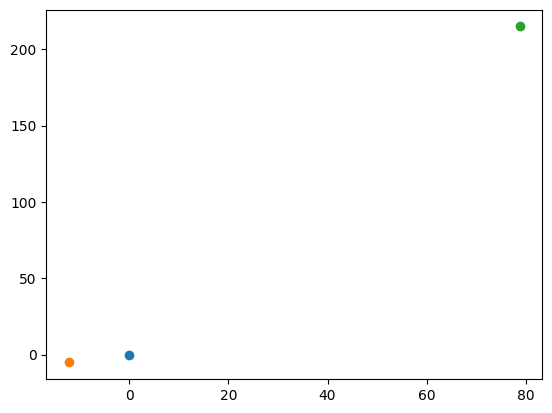

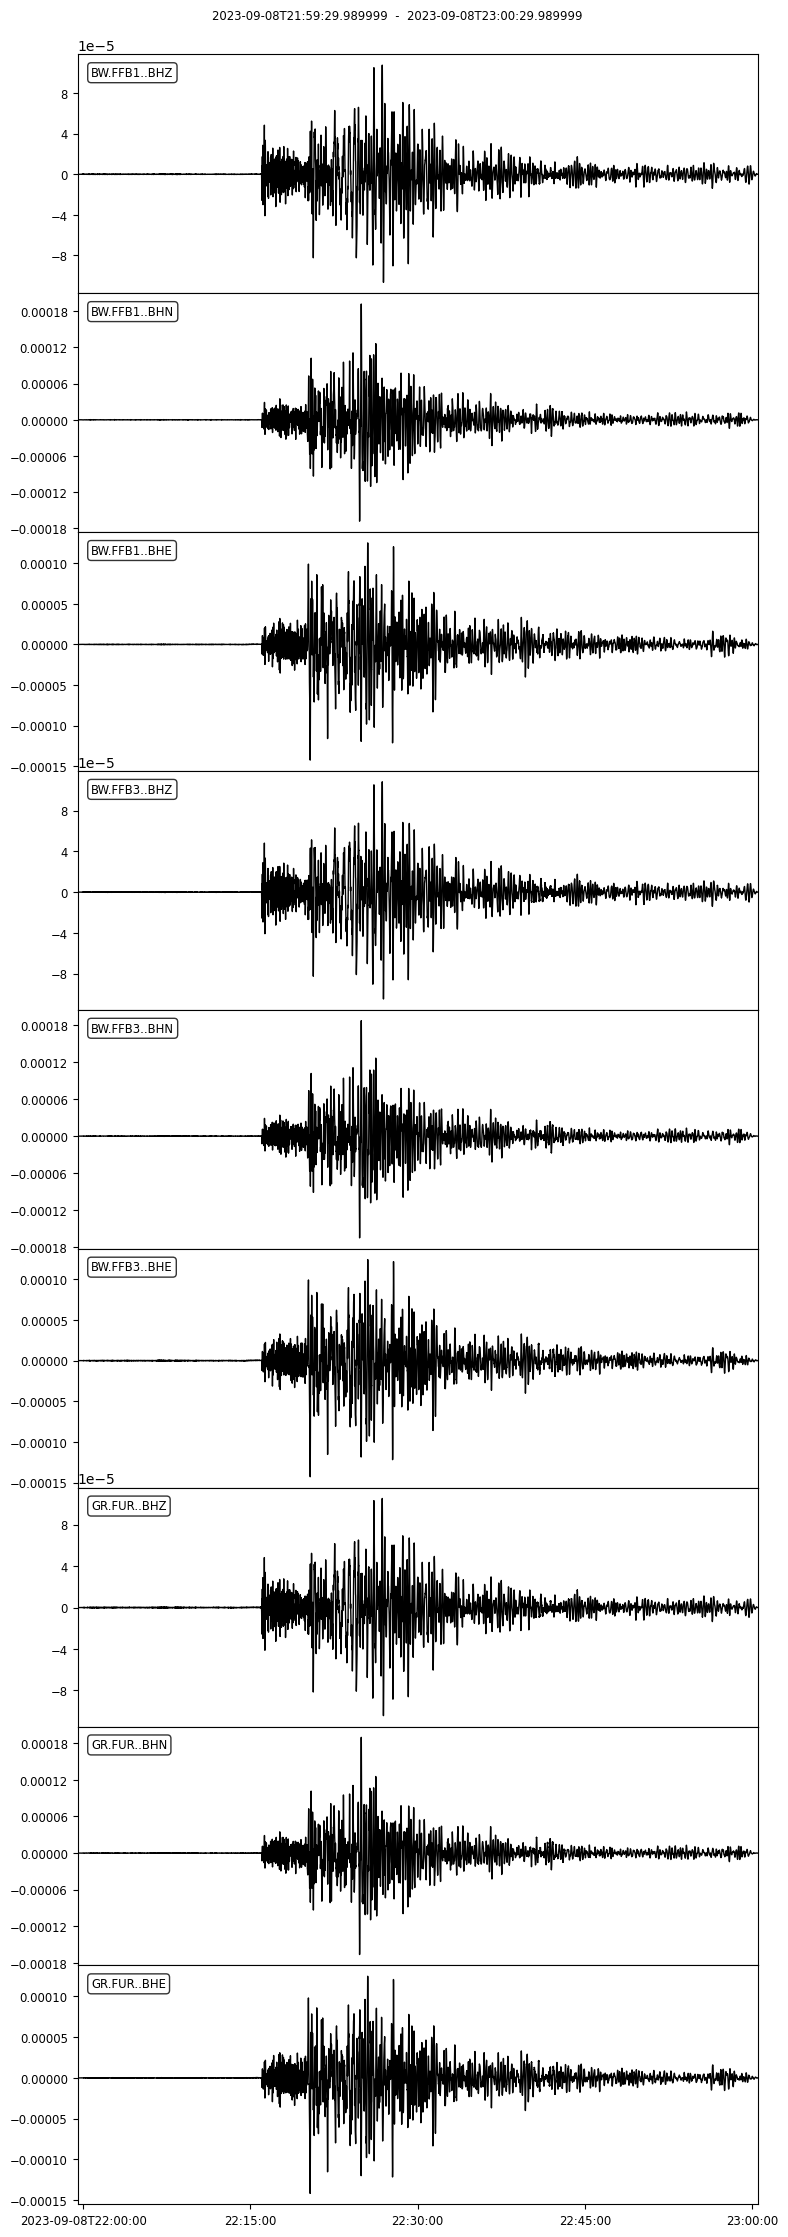


 -> Runtime: 0.58 minutes



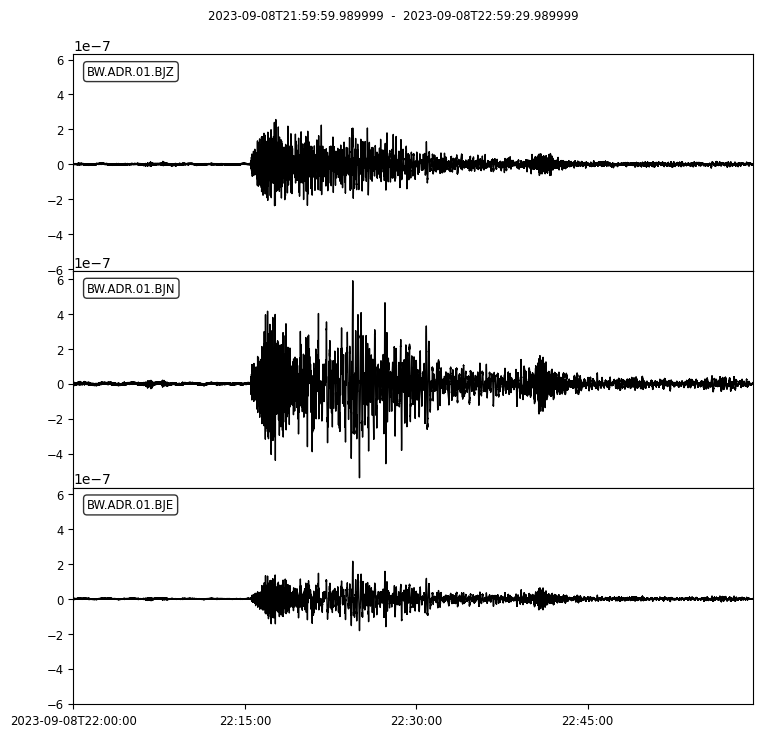

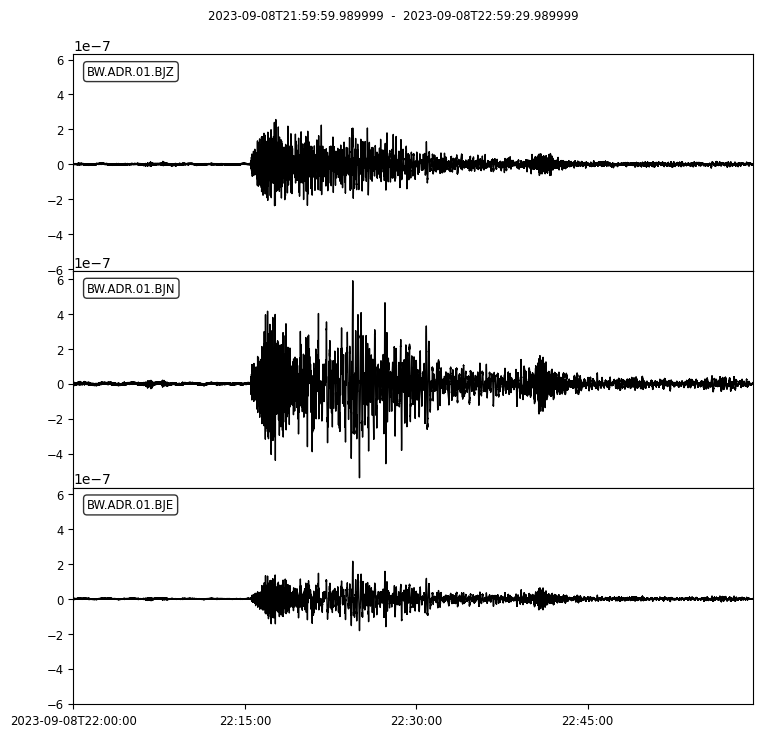

In [96]:
if config['adr']:
    iadr, status = __compute_adr_pfo(config['tbeg'],
                                     config['tend'],
                                     submask="inner",
                                     status=False,
                                     excluded_stations=["BW.FFB2"],
                                    )
    iadr.plot();

 -> load jane inventory
 -> obtained: GR.FUR
3 Trace(s) in Stream:
GR.FUR..BHE | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
GR.FUR..BHN | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
GR.FUR..BHZ | 2023-09-08T21:59:29.989999Z - 2023-09-08T23:00:29.989999Z | 20.0 Hz, 73201 samples
 -> load jane inventory
 -> obtained: BW.BIB
3 Trace(s) in Stream:
BW.BIB..BHE | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:30.000000Z | 20.0 Hz, 73201 samples
BW.BIB..BHZ | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:30.000000Z | 20.0 Hz, 73201 samples
BW.BIB..BHN | 2023-09-08T21:59:30.000000Z - 2023-09-08T23:00:30.000000Z | 20.0 Hz, 73201 samples
 -> load jane inventory
 -> obtained: BW.TON
3 Trace(s) in Stream:
BW.TON..BHN | 2023-09-08T21:59:29.987500Z - 2023-09-08T23:00:29.987500Z | 20.0 Hz, 73201 samples
BW.TON..BHE | 2023-09-08T21:59:29.987500Z - 2023-09-08T23:00:29.987500Z | 20.0 Hz, 73201 samples
BW.TON..BHZ | 2023-09-0

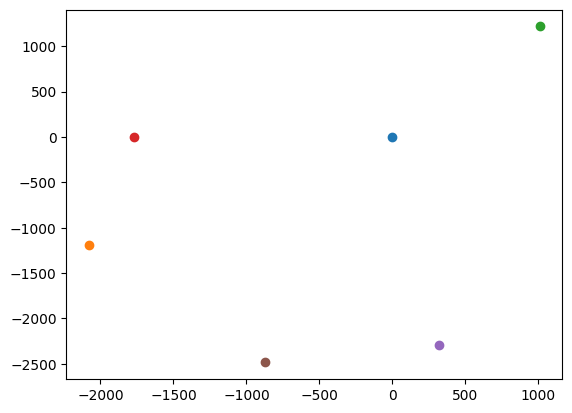

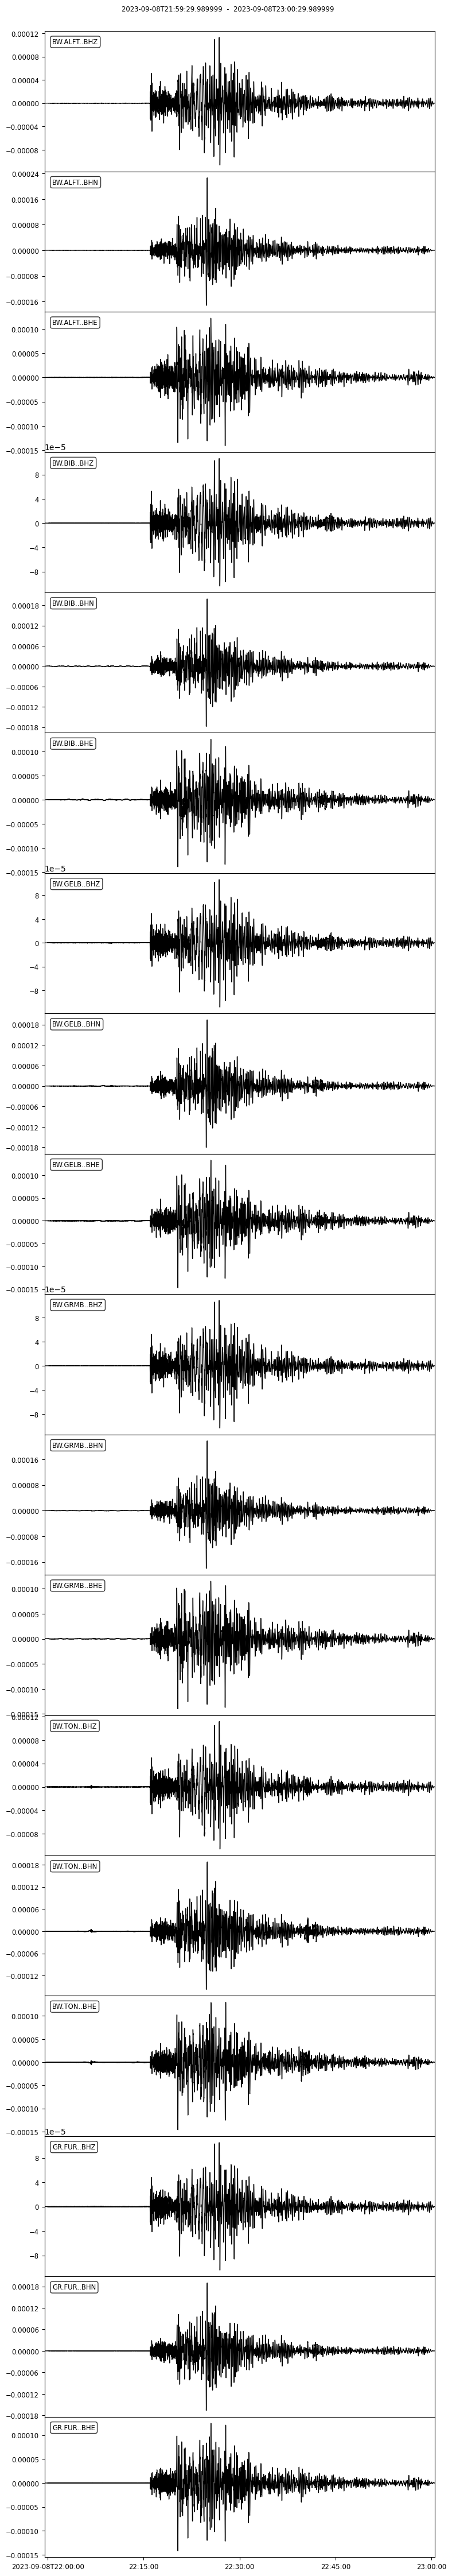


 -> Runtime: 1.96 minutes



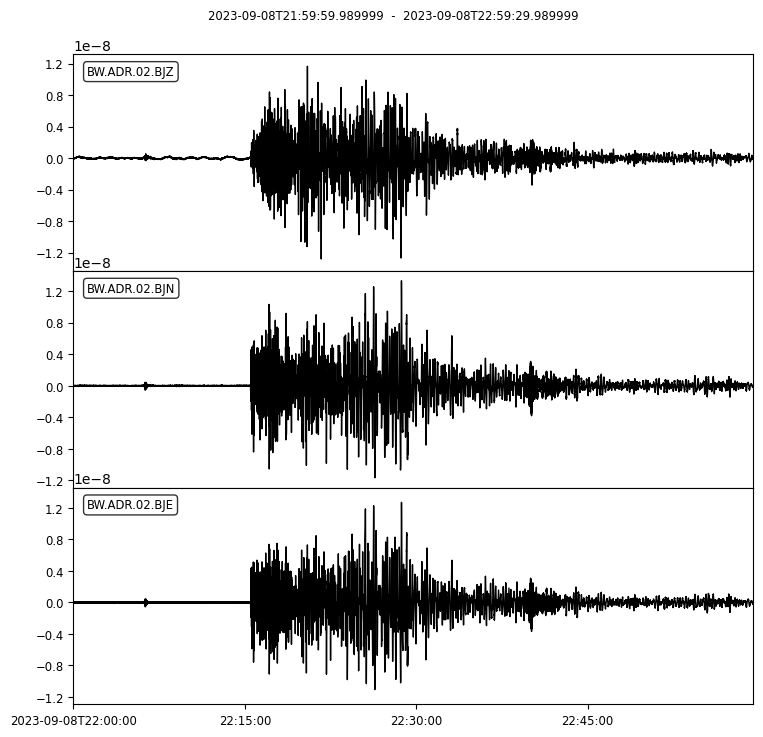

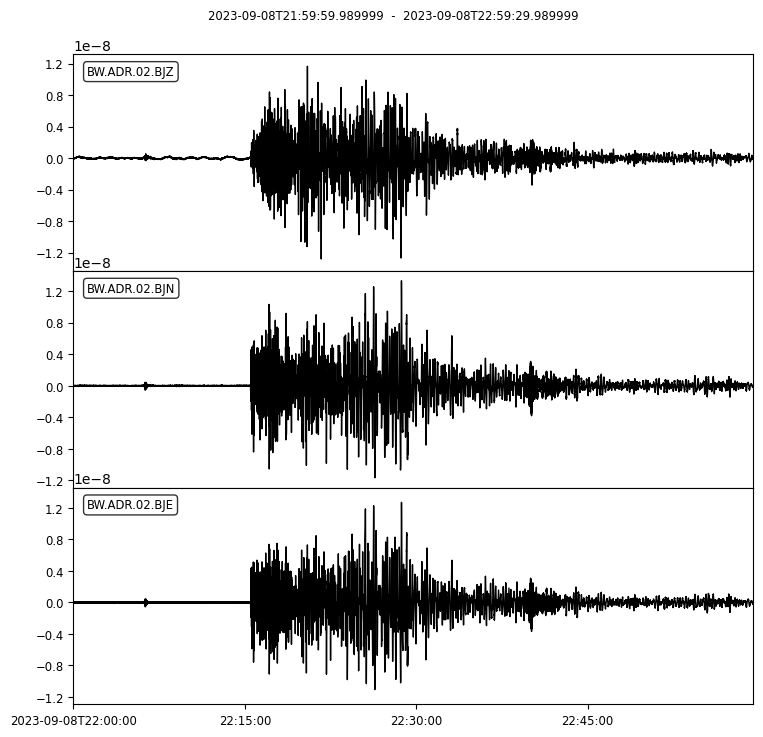

In [101]:
if config['adr']:
    oadr, status = __compute_adr_pfo(config['tbeg'],
                                     config['tend'],
                                     submask="outer",
                                     status=False,
                                     excluded_stations=["BW.ALFT"],
                                    )
    oadr.plot();

In [98]:
stx = obs.Stream()
stx += __read_sds(config['path_to_sds'], "BW.ROMY.20.BJZ", config['tbeg']-1, config['tend']+1)
stx += __read_sds(config['path_to_sds'], "BW.ROMY.20.BJN", config['tbeg']-1, config['tend']+1)
stx += __read_sds(config['path_to_sds'], "BW.ROMY.20.BJE", config['tbeg']-1, config['tend']+1)

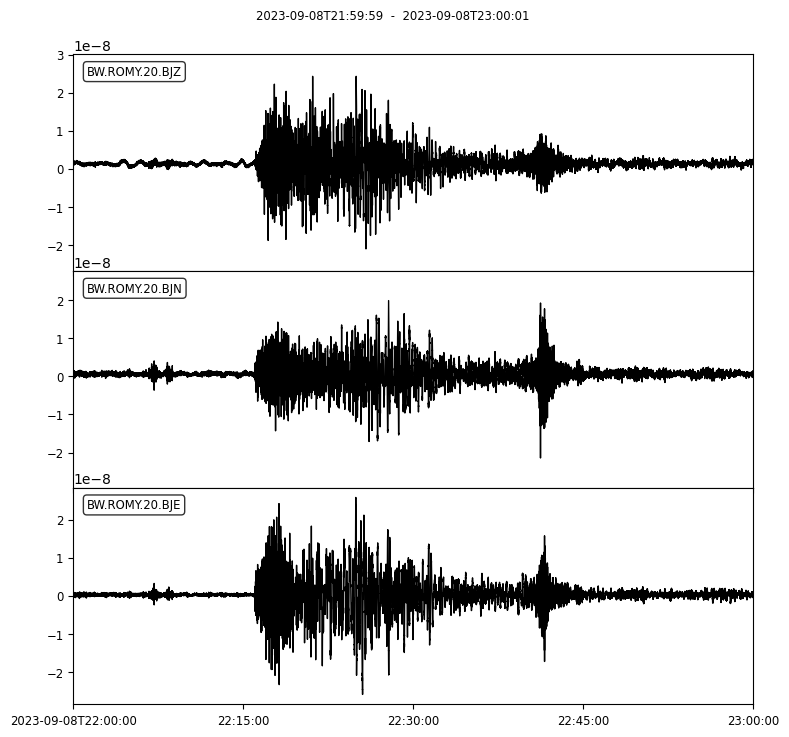

In [99]:
stx.plot();

### Plot Waveforms

In [ ]:
from functions.makeplot_waveforms import __makeplot_waveforms

In [ ]:
fig = __makeplot_waveforms(acc, rot_zne)

## Compare Waveforms

In [ ]:
def __makeplot_waveform_comparison(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(channel="*Z")[0].times(), st1.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(st1.select(channel="*U")[0].times(), st1.select(channel="*U")[0].data*rot_scaling, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data*rot_scaling, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(st1.select(channel="*V")[0].times(), st1.select(channel="*V")[0].data*rot_scaling, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data*rot_scaling, lw=lw, label="E", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 10)
    ax00.set_ylabel("Z - Z (nrad/s)", color="darkgrey")

    ax11 = ax[1].twinx()
    diff_N = ( abs(st1.select(channel="*U")[0].data - st2.select(channel="*N")[0].data)*rot_scaling )
    ax11.fill_between(st2.select(channel="*N")[0].times(), diff_N, color="grey", alpha=0.5, zorder=1)
    ax11.set_ylim(-1, 10)
    ax11.set_ylabel("U - N (nrad/s)", color="darkgrey")

    ax22 = ax[2].twinx()
    diff_E = ( abs(st1.select(channel="*V")[0].data - st2.select(channel="*E")[0].data)*rot_scaling )
    ax22.fill_between(st2.select(channel="*E")[0].times(), diff_E, color="grey", alpha=0.5, zorder=1)
    ax22.set_ylim(-1, 10)
    ax22.set_ylabel("V - E (nrad/s)", color="darkgrey")

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

In [ ]:
config['fmin'] = 0.01
config['fmax'] = 0.1

st_cp = rot.copy()
st_cp = st_cp.detrend("demean");
st_cp = st_cp.taper(0.01);
st_cp = st_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st_cp.trim(config['tbeg'], config['tend'])

st_rot_cp = rot_zne.copy()
st_rot_cp = st_rot_cp.detrend("demean");
st_rot_cp = st_rot_cp.taper(0.01);
st_rot_cp = st_rot_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

st_rot_cp.trim(config['tbeg'], config['tend'])

st_acc_cp = acc.copy()
st_acc_cp = st_acc_cp.detrend("demean");
st_acc_cp = st_acc_cp.taper(0.01);
st_acc_cp = st_acc_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);


fig = __makeplot_waveform_comparison(st_cp, st_rot_cp)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');


In [ ]:
def __makeplot_spectra_comparison(st1, st2):

    def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=0)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        ## 95% confidence interval
        # _psd95 = out_psd.jackspec()
        # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

        return f, psd

    Tsec = 5
    f1_Z, psd1_Z = __multitaper_psd(st1.select(channel="*Z")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_Z, psd2_Z = __multitaper_psd(st2.select(channel="*Z")[0].data, st2[0].stats.delta ,n_win=Tsec)

    f1_U, psd1_U = __multitaper_psd(st1.select(channel="*U")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_N, psd2_N = __multitaper_psd(st2.select(channel="*N")[0].data, st2[0].stats.delta ,n_win=Tsec)

    f1_V, psd1_V = __multitaper_psd(st1.select(channel="*V")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_E, psd2_E = __multitaper_psd(st2.select(channel="*E")[0].data, st2[0].stats.delta ,n_win=Tsec)


    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(f1_Z, psd1_Z, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(f2_Z, psd2_Z, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(f1_U, psd1_U, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(f2_N, psd2_N, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(f1_V, psd1_V, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(f2_E, psd2_E, lw=lw, label="E", color="black", zorder=2)


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].set_xscale("log")
        # ax[i].set_yscale("log")
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)")
        # ax[i].set_xlim(2e-2, 2e-1)

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

In [ ]:
# fig = __makeplot_spectra_comparison(st_cp, st_rot_cp)

In [ ]:
# fig = __makeplot_spectra_comparison(rot, adr)

In [ ]:
# fig = __makeplot_waveforms(st_acc_cp, st_rot_cp)

## Write Data

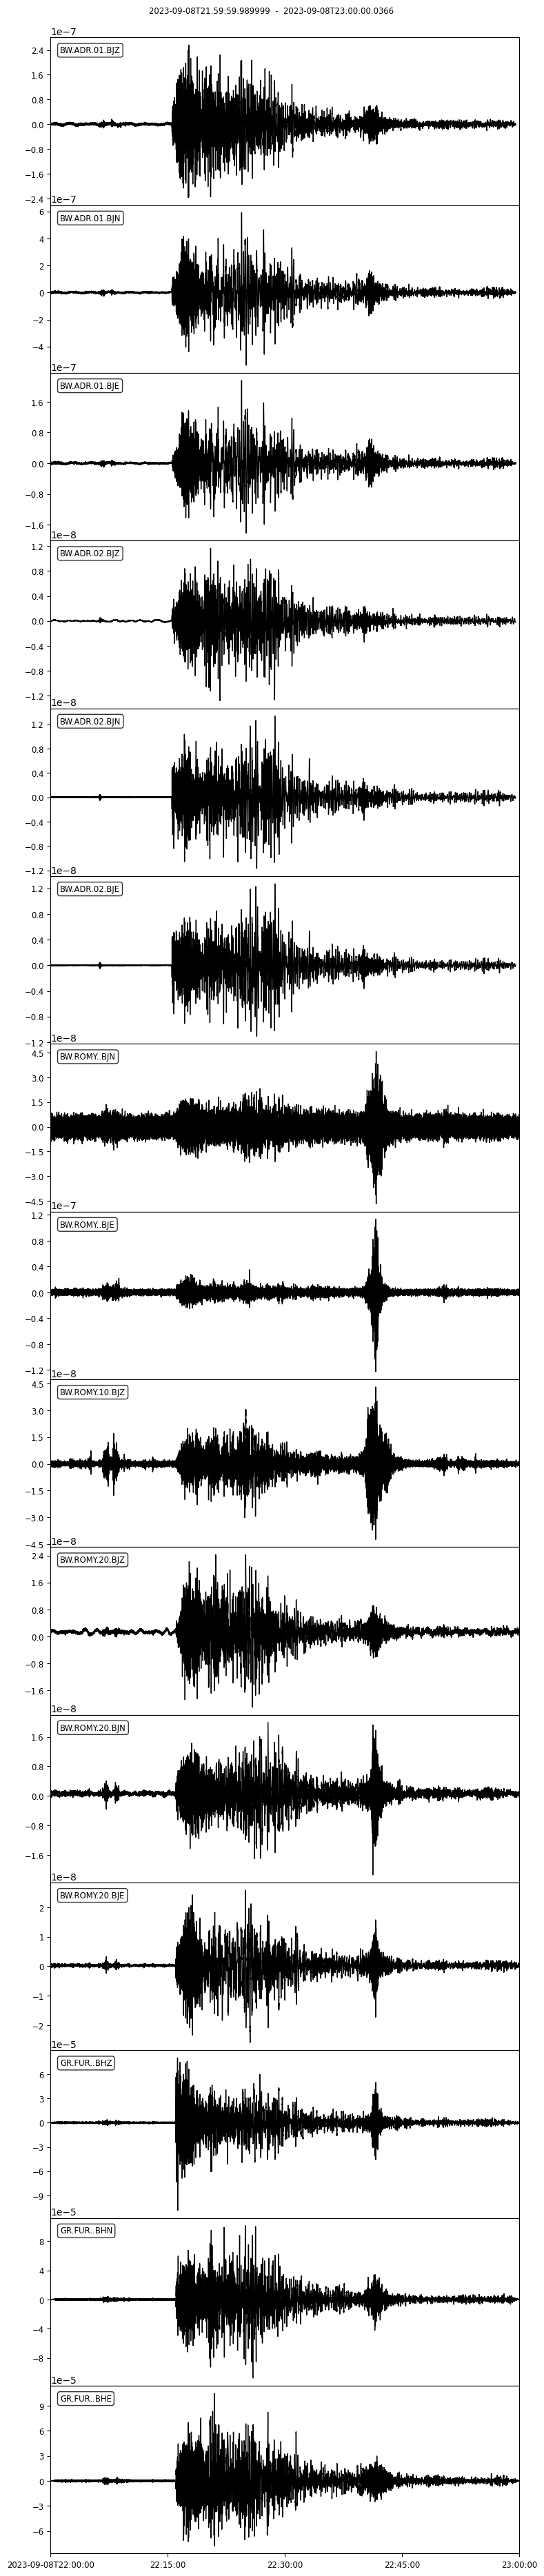

-> store:  /import/kilauea-data/romy_events/data/ROMY_FUR_Morocco_20230908_6C.mseed


In [102]:
st_all = rot_zne.copy();
st_all += acc.copy();

if config['adr']:
    st_all += iadr.copy();
    st_all += oadr.copy();


st_all += stx.copy();



st_all = st_all.trim(config['tbeg'], config['tend'])

st_all.plot(equal_scale=False);

# filename = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_{str(config['tbeg'].time).split('.')[0]}_6C.mseed"
filename = f"{rot_zne[0].stats.station}_{acc[0].stats.station}_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"
print(f"-> store: ", config['path_to_outdata']+filename)
st_all.write(config['path_to_outdata']+filename, format="MSEED");
